<a href="https://colab.research.google.com/github/warn4n/dl2025/blob/main/Notebooks/Chap13/13_2_Graph_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 13.2: Graph classification**

This notebook investigates representing graphs with matrices as illustrated in figure 13.4 from the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Let's build a model that maps a chemical structure to a binary decision.  This model might be used to predict whether a chemical is liquid at room temperature or not.  We'll start by drawing the chemical structure.

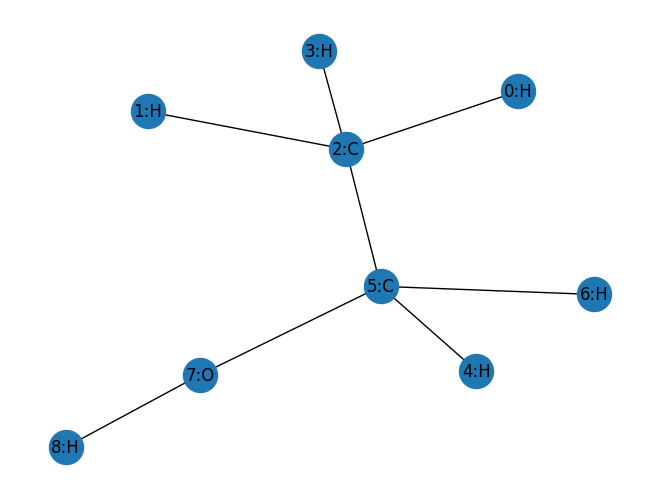

In [2]:
# Define a graph that represents the chemical structure of ethanol and draw it
# Each node is labelled with the node number and the element (carbon, hydrogen, oxygen)
G = nx.Graph()
G.add_edge('0:H','2:C')
G.add_edge('1:H','2:C')
G.add_edge('3:H','2:C')
G.add_edge('2:C','5:C')
G.add_edge('4:H','5:C')
G.add_edge('6:H','5:C')
G.add_edge('7:O','5:C')
G.add_edge('8:H','7:O')
nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True, node_size=600)
plt.show()

In [4]:
# Define adjacency matrix
# TODO -- Define the adjacency matrix for this chemical
# Replace this line
A = np.zeros((9,9)) ;
for edge in G.edges:
  A[int(edge[0].split(':')[0]), int(edge[1].split(':')[0])] = 1
  A[int(edge[1].split(':')[0]), int(edge[0].split(':')[0])] = 1


print(A)

# TODO -- Define node matrix
# There will be 9 nodes and 118 possible chemical elements
# so we'll define a 118x9 matrix.  Each column represents one
# node and is a one-hot vector (i.e. all zeros, except a single one at the
# chemical number of the element).
# Chemical numbers:  Hydrogen-->1, Carbon-->6,  Oxygen-->8
# Since the indices start at 0, we'll set element 0 to 1 for hydrogen, element 5
# to one for carbon, and element 7 to one for oxygen
# Replace this line:
X = np.zeros((118,9))
for n in G.nodes:
  symbol = n.split(':')[1]
  if symbol == 'H':
    X[0,int(n.split(':')[0])] = 1
  elif symbol == 'C':
    X[5,int(n.split(':')[0])] = 1
  elif symbol == 'O':
    X[7,int(n.split(':')[0])] = 1

print(X)

# Print the top 15 rows of the data matrix
print(X[0:15,:])

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[[1. 1. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Now let's define a network with four layers that maps this graph to a binary value, using the formulation in equation 13.11.

In [5]:
# We'll need these helper functions

# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Define the logistic sigmoid function
def sigmoid(x):
  return 1.0/(1.0+np.exp(-x))

In [6]:
# Our network will have K=3 hidden layers, and will use a dimension of D=200.
K = 3; D = 200
# Set seed so we always get the same random numbers
np.random.seed(1)
# Let's initialize the parameter matrices randomly with He initialization
Omega0 = np.random.normal(size=(D, 118)) * 2.0 / D
beta0 = np.random.normal(size=(D,1)) * 2.0 / D
Omega1 = np.random.normal(size=(D, D)) * 2.0 / D
beta1 = np.random.normal(size=(D,1)) * 2.0 / D
Omega2 = np.random.normal(size=(D, D)) * 2.0 / D
beta2 = np.random.normal(size=(D,1)) * 2.0 / D
omega3 = np.random.normal(size=(1, D))
beta3 = np.random.normal(size=(1,1))

In [ ]:
def graph_neural_network(A,X, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3):
  # Define this network according to equation 13.11 from the book
  # Replace this line
  h1 = ReLU(beta0 + )

  return f;

In [ ]:
# Let's test this network
f = graph_neural_network(A,X, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3)
print("Your value is %3f: "%(f[0,0]), "True value of f: 0.310843")

In [ ]:
# Let's check that permuting the indices of the graph doesn't change
# the output of the network
# Define a permutation matrix
P = np.array([[0,1,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0],
              [0,0,0,0,0,1,0,0,0],
              [0,0,0,0,0,0,0,0,1],
              [1,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,0,0,1,0],
              [0,0,0,0,0,0,1,0,0]]);

# TODO -- Use this matrix to permute the adjacency matrix A and node matrix X
# Replace these lines
A_permuted = np.copy(A)
X_permuted = np.copy(X)

f = graph_neural_network(A_permuted,X_permuted, Omega0, beta0, Omega1, beta1, Omega2, beta2, omega3, beta3)
print("Your value is %3f: "%(f[0,0]), "True value of f: 0.310843")

TODO -- encode the adjacency matrix and node matrix for propanol and run the network again.  Show that the network still runs even though the size of the input graph is different.

Propanol structure can be found [here](https://upload.wikimedia.org/wikipedia/commons/b/b8/Propanol_flat_structure.png).